# RESULTS 

In [ ]:
import numpy as np

def compute_cmc(ranks, max_rank=30):
    cmc = np.zeros(max_rank)
    for k in range(1, max_rank + 1):
        cmc[k - 1] = np.sum(np.array(ranks) <= k) / len(ranks)
    return cmc

def compute_map(ranks):
    aps = []
    for r in ranks:
        if np.isfinite(r):
            aps.append(1.0 / r)
        else:
            aps.append(0.0)
    return np.mean(aps)

def compute_mrr(ranks):
    reciprocal_ranks = [1.0 / r if np.isfinite(r) else 0.0 for r in ranks]
    return np.mean(reciprocal_ranks)

def compute_ndcg(ranks, max_rank=30):
    def dcg(rank):
        return 1.0 / np.log2(rank + 1) if np.isfinite(rank) else 0.0
    
    ideal_dcg = np.sum([1.0 / np.log2(i + 2) for i in range(min(len(ranks), max_rank))])
    dcg_val = np.sum([dcg(r) for r in ranks[:max_rank]])
    
    return dcg_val / ideal_dcg if ideal_dcg > 0 else 0.0

def print_metrics(name, cmc, mAP, mrr, ndcg):
    print(f"{name}:")
    print(f"  Rank-1:  {cmc[0]:.3f}")
    print(f"  Rank-5:  {cmc[4]:.3f}")
    print(f"  mAP:     {mAP:.3f}")
    print(f"  MRR:     {mrr:.3f}")
    print(f"  nDCG:    {ndcg:.3f}")
    print()

In [6]:
def bootstrap_metrics(ranks, num_samples=1000, max_rank=30):
    ranks = np.array(ranks)
    n = len(ranks)
    cmc_all = []
    map_all = []
    mrr_all = []
    ndcg_all = []

    for _ in range(num_samples):
        sample = np.random.choice(ranks, size=n, replace=True)
        cmc = compute_cmc(sample, max_rank=max_rank)
        ap = compute_map(sample)
        mrr = compute_mrr(sample)
        ndcg = compute_ndcg(sample, max_rank=max_rank)

        cmc_all.append(cmc)
        map_all.append(ap)
        mrr_all.append(mrr)
        ndcg_all.append(ndcg)

    cmc_all = np.array(cmc_all)
    map_all = np.array(map_all)
    mrr_all = np.array(mrr_all)
    ndcg_all = np.array(ndcg_all)

    return {
        "rank1_mean": cmc_all[:, 0].mean(),
        "rank1_std": cmc_all[:, 0].std(),
        "rank5_mean": cmc_all[:, 4].mean(),
        "rank5_std": cmc_all[:, 4].std(),
        "map_mean": map_all.mean(),
        "map_std": map_all.std(),
        "mrr_mean": mrr_all.mean(),
        "mrr_std": mrr_all.std(),
        "ndcg_mean": ndcg_all.mean(),
        "ndcg_std": ndcg_all.std(),
    }


In [3]:
def bootstrap_cmc(ranks, max_rank=30, n_bootstrap=1000, ci=0.7):
    cmc_matrix = np.zeros((n_bootstrap, max_rank))
    n = len(ranks)
    
    for i in range(n_bootstrap):
        sample = np.random.choice(ranks, size=n, replace=True)
        cmc_matrix[i] = compute_cmc(sample, max_rank)
    
    lower = np.percentile(cmc_matrix, (1-ci)*100/2, axis=0)
    upper = np.percentile(cmc_matrix, 100-(1-ci)*100/2, axis=0)
    mean = np.mean(cmc_matrix, axis=0)
    
    return mean, lower, upper

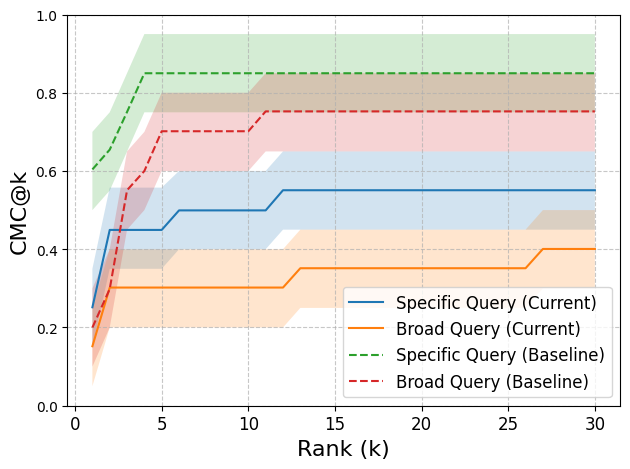

In [4]:
import matplotlib.pyplot as plt

specific_ranks = [
    np.inf, 12, 1, np.inf, 1, 6, 2, 2, 1, np.inf, 1, np.inf, 2, 
    np.inf, np.inf, 1, np.inf, np.inf, np.inf, 2
    ]
broad_ranks = [
    np.inf, np.inf, 2, np.inf, 1, 27, 13, 1, np.inf, np.inf, 
    np.inf, np.inf, np.inf, np.inf, 2, 2, np.inf, np.inf, np.inf, 1
    ]


specific_ranks_baseline= [
    np.inf, 3, 3, np.inf, 1, 1, 1, 1, 1, 1,
    4, 2, 1, np.inf, 4, 1, 1, 1, 1, 1
]
broad_ranks_baseline = [
    np.inf, 3, 1, 5, 3, 2, 5, 3, 1, np.inf,
    1, 3, 4, np.inf, np.inf, 3, 2, np.inf, 1, 11
]


mean_spec, lower_spec, upper_spec = bootstrap_cmc(specific_ranks)
mean_broad, lower_broad, upper_broad = bootstrap_cmc(broad_ranks)
mean_spec_base, lower_spec_base, upper_spec_base = bootstrap_cmc(specific_ranks_baseline)
mean_broad_base, lower_broad_base, upper_broad_base = bootstrap_cmc(broad_ranks_baseline)


ranks = range(1, 31)

plt.plot(ranks, mean_spec, label='Specific Query (Current)')
plt.fill_between(ranks, lower_spec, upper_spec, alpha=0.2)

plt.plot(ranks, mean_broad, label='Broad Query (Current)')
plt.fill_between(ranks, lower_broad, upper_broad, alpha=0.2)

plt.plot(ranks, mean_spec_base, linestyle='--', label='Specific Query (Baseline)')
plt.fill_between(ranks, lower_spec_base, upper_spec_base, alpha=0.2)

plt.plot(ranks, mean_broad_base, linestyle='--', label='Broad Query (Baseline)')
plt.fill_between(ranks, lower_broad_base, upper_broad_base, alpha=0.2)

plt.xlabel('Rank (k)', fontsize=16)
plt.xticks(fontsize= 12)
plt.ylabel('CMC@k', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("../report/fig/cmc.png")


In [8]:
# Bootstrap evaluation
metrics_spec_current = bootstrap_metrics(specific_ranks)
metrics_broad_current = bootstrap_metrics(broad_ranks)
metrics_spec_baseline = bootstrap_metrics(specific_ranks_baseline)
metrics_broad_baseline = bootstrap_metrics(broad_ranks_baseline)

def print_bootstrap_metrics(name, metrics):
    print(f"{name}")
    print(f"  Rank-1: {metrics['rank1_mean']:.3f} ± {metrics['rank1_std']:.3f}")
    print(f"  Rank-5: {metrics['rank5_mean']:.3f} ± {metrics['rank5_std']:.3f}")
    print(f"  mAP:    {metrics['map_mean']:.3f} ± {metrics['map_std']:.3f}")
    print(f"  MRR:    {metrics['mrr_mean']:.3f} ± {metrics['mrr_std']:.3f}")
    print(f"  nDCG:   {metrics['ndcg_mean']:.3f} ± {metrics['ndcg_std']:.3f}")
    print()


print_bootstrap_metrics("Specific Query (Current)", metrics_spec_current)
print_bootstrap_metrics("Broad Query (Current)", metrics_broad_current)
print_bootstrap_metrics("Specific Query (Baseline)", metrics_spec_baseline)
print_bootstrap_metrics("Broad Query (Baseline)", metrics_broad_baseline)

Specific Query (Current)
  Rank-1: 0.248 ± 0.102
  Rank-5: 0.448 ± 0.112
  mAP:    0.361 ± 0.096
  MRR:    0.361 ± 0.096
  nDCG:   1.155 ± 0.272

Broad Query (Current)
  Rank-1: 0.156 ± 0.083
  Rank-5: 0.305 ± 0.104
  mAP:    0.236 ± 0.085
  MRR:    0.236 ± 0.085
  nDCG:   0.778 ± 0.244

Specific Query (Baseline)
  Rank-1: 0.599 ± 0.109
  Rank-5: 0.849 ± 0.081
  mAP:    0.683 ± 0.090
  MRR:    0.683 ± 0.090
  nDCG:   2.056 ± 0.237

Broad Query (Baseline)
  Rank-1: 0.199 ± 0.088
  Rank-5: 0.699 ± 0.101
  mAP:    0.369 ± 0.078
  MRR:    0.369 ± 0.078
  nDCG:   1.309 ± 0.214

